In [34]:
import tensorflow as tf
from PIL import Image
import PIL
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [35]:
def create_mask(image_size,bbox):
  mask=np.zeros(image_size,dtype=np.uint8)
  x_min,y_min,x_max,y_max=bbox
  mask[y_min:y_max,x_min:x_max]=1
  return mask

In [36]:
image_size=(100,100)
bbox=(10,20,30,40)

In [37]:
mask=create_mask(image_size,bbox)
mask_tensor=tf.convert_to_tensor(mask,tf.uint8)

In [38]:
mask_tensor

<tf.Tensor: shape=(100, 100), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [39]:
mask_image=Image.fromarray(mask*255)
mask_image.save("mask.png")

In [40]:
detector=hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

In [41]:


def object_detect(image_data):
    image_tensor = tf.convert_to_tensor(image_data)
    image_tensor = image_tensor[tf.newaxis, ...]
    detector_output = detector(image_tensor)
    detection_boxes = detector_output["detection_boxes"][0].numpy()
    detection_scores = detector_output["detection_scores"][0].numpy()
    detection_classes = detector_output["detection_classes"][0].numpy()
    confidence_label = 0.5
    masks = []  # Use a Python list to store masks
    annotations = []

    for i in range(detection_boxes.shape[0]):
        if detection_scores[i] > confidence_label:
            y_min, x_min, y_max, x_max = detection_boxes[i]
            y_min, x_min, y_max, x_max = int(y_min * image_data.shape[0]), int(x_min * image_data.shape[1]), int(y_max * image_data.shape[0]), int(x_max * image_data.shape[1])

            mask = np.zeros(image_data.shape[:2], dtype=np.uint8)
            mask[y_min:y_max, x_min:x_max] = 1
            masks.append(mask)  # Append the mask to the list
            annotations.append({"box": [x_min, y_min, x_max, y_max], "class": detection_classes[i],
                                "score": detection_scores[i]})

    return masks, annotations




In [42]:
image_data = "/content/image_data.jpg"
image_data_numpy_array = np.array(Image.open(image_data))
masks, annotations = object_detect(image_data_numpy_array)
print("Mask Information", masks)
print("\nAnnotations Information", annotations)

Mask Information [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

Annotations Information [{'box': [233, 36, 625, 858], 'class': 1.0, 'score': 0.8069524}, {'box': [77, 394, 879, 949], 'class': 2.0, 'score': 0.650809}, {'box': [16, 220, 289, 478], 'class': 3.0, 'score': 0.64925694}]


In [43]:
def image_segmentation(image_data,masks,annotations):
  plt.figure(figsize=(10,7))
  plt.subplot(1,3,1)
  plt.imshow(image_data)
  plt.title("Orginal Image")

  plt.subplot(1,3,2)
  plt.imshow(image_data)
  plt.imshow(masks[0],cmap="jet",alpha=0.5)
  plt.title("Orginal Image with mask")

  plt.subplot(1,3,3)
  for annot in annotations:
    x_min,y_min,x_max,y_max=annot["box"]
    plt.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],"r-")
  plt.imshow(image_data)

  plt.title("Orginal Image with Bounding Box")
  plt.show()

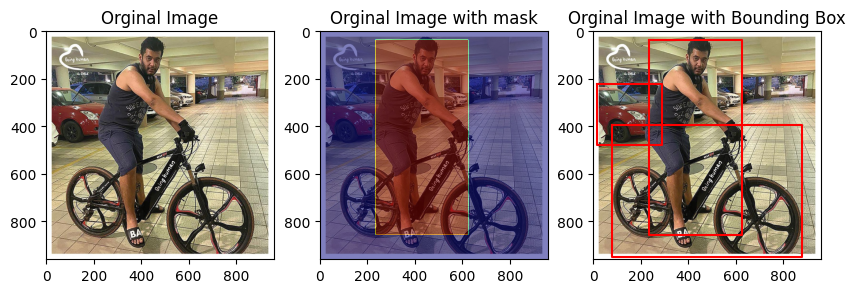

In [44]:
image_segmentation(image_data_numpy_array,masks,annotations)

In [45]:
import matplotlib.patches as patches

In [46]:
def batch_functions(tensor_image, model, th=0.5):
    batched_images = tf.stack(tensor_image, axis=0)
    batch_mask = []
    batch_annotations = []
    detector_output = model(batched_images)  # Assuming 'detector' is the model you're using

    for i in range(batched_images.shape[0]):
        detection_boxes = detector_output["detection_boxes"][i].numpy()
        detection_scores = detector_output["detection_scores"][i].numpy()
        detection_classes = detector_output["detection_classes"][i].numpy()

        masks = []  # Use a Python list to store masks
        annotations = []

        for j in range(detection_boxes.shape[0]):
            if detection_scores[j] > th:
                y_min, x_min, y_max, x_max = detection_boxes[j]
                y_min, x_min, y_max, x_max = int(y_min * tensor_image.shape[1]), int(x_min * tensor_image.shape[2]), int(y_max * tensor_image.shape[1]), int(x_max * tensor_image.shape[2])

                mask = np.zeros(tensor_image.shape[1:3], dtype=np.uint8)
                mask[y_min:y_max, x_min:x_max] = 1
                masks.append(mask)  # Append the mask to the list
                annotations.append({"box": [x_min, y_min, x_max, y_max], "class": detection_classes[j],
                                    "score": detection_scores[j]})

        batch_mask.append(masks)
        batch_annotations.append(annotations)

        # Debug prints
        print(f"Number of masks in batch {i}: {len(masks)}")

    return batch_mask, batch_annotations


In [47]:
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

image_data = ["/content/mask.png"]
model_image_size = (320, 320)
model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")
images = []

for image_path in image_data:
    img = load_img(image_path, target_size=model_image_size)
    array_image = img_to_array(img).astype("uint8")
    images.append(array_image)

tensor_image = tf.convert_to_tensor(images, dtype=tf.uint8)
batch_mask, batch_annotations = batch_functions(tensor_image, model)

def image_visualization(image_data, masks, annotations):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(image_data)

    for mask in masks:
        masked_image = np.ma.masked_where(mask == 0, mask)
        ax.imshow(masked_image, cmap="jet", alpha=0.5)

    for annot in annotations:
        x_min, y_min, x_max, y_max = annot["box"]
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="b", facecolor="none")
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()


Number of masks in batch 0: 0


In [48]:
image_visualize=images[0]
mask_visualize=batch_mask[0]
annotate_visualize=batch_annotations[0]

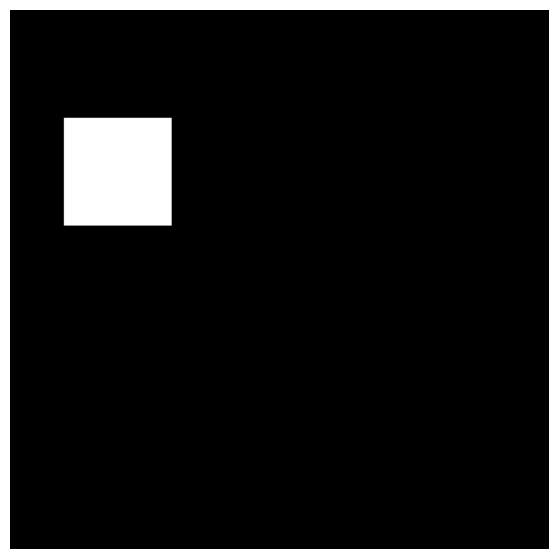

In [49]:
image_visualization(image_visualize,mask_visualize,annotate_visualize)